# Surface Mass Balance: PCA 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

Set WD

#### Load KM_L 

In [98]:
#df = pd.read_csv(r'..\data\promice\preprocessed\daily\KAN_L.csv', index_col=0)
df = pd.read_csv(r'../data/promice/preprocessed/daily/SCO_L.csv', index_col=0)

## PCA

##### Pre-processing (0.1: Change months to cycle)

In [99]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
#df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
#df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [100]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# with year
#cyclical = cyclical.fit_transform(df[['month', 'year', 'Wind from direction (upper boom)']]) 

# Remove only values from Wind direction because CyclicalFeatures does not work with NAN
df = df[df['Wind from direction (upper boom)'].notna()] 

# without year 
#cyclical = cyclical.fit_transform(df[['month', 'Wind from direction (upper boom)']]) 

# without month
cyclical = cyclical.fit_transform(df[['Wind from direction (upper boom)']]) 
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df.drop(columns=['month', 'Wind from direction (upper boom)'], inplace=True)

##### Pre-processing (1.0: Filter relevant periods)

In [101]:
# Fill NA values in Melting season as blank
df['Melting Season'] = df['Melting Season'].fillna('no_ablation')

In [102]:
#Only Ablation Period

df = df[df['Ablation'] == True]

#Only Melting Season
#df =  df[df['Melting Season'].isin(['pre', 'beginning', 'middle', 'end'])]

#On all periods (without NA)
#df = df.dropna()

df = df.reset_index(drop=True)

In [103]:
# This bit retrieve the indexes for all melting season categories and remove column from df
periods = ['all','no_ablation','pre','beginning', 'middle','end']

for category in ['no_ablation', 'pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

indices_all = df[df['Ablation'].isin([True, False])].index

#df.drop(columns=['Melting Season'], inplace=True) 

indices_beginning

Int64Index([  40,   41,   42,   43,   44,   45,   46,   47,   48,   49,
            ...
            1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122],
           dtype='int64', length=186)

##### This bit to apply PCA and save as output df

In [104]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

scaler = MinMaxScaler()

#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'month_sin', 'month_cos', 'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos',  'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature

df[num_cols] = df[num_cols].ffill().bfill()
df[num_cols] = scaler.fit_transform(df[num_cols])

pca_col = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature



pca = PCA()
pca.fit(df[pca_col])

# calculate the cumulative variance explained by each PC
cumulative_var = np.cumsum(pca.explained_variance_ratio_)
n_components = np.argmax(cumulative_var > 0.9) + 1  # select the minimum number of PCs that explain at least 90% of the variance

# fit PCA with the selected number of components
pca = PCA(n_components=n_components)
pca_data = pca.fit_transform(df[pca_col])

# create a new dataframe with the PCA columns
pca_df = pd.DataFrame(pca_data, columns=['PC'+str(i) for i in range(1, n_components+1)])

# concatenate the original dataframe without the PCA columns with the PCA dataframe
original_df = df.drop(columns=pca_col)
result_df = pd.concat([original_df, pca_df], axis=1)

station = df.iloc[0]['stid']
result_df.to_csv(r'../data/promice/preprocessed/daily/{station}_PCA.csv'.format(station=station))


##### This bit to analysze PCA for different periods  

In [29]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# This bit to convert all numerical values into the same scale 
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Wind from direction (upper boom)_sin', 'Wind from direction (upper boom)_cos', 'month_sin', 'month_cos', 'Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y and cyclical feature


scaler = MinMaxScaler()
scaler = StandardScaler()


df[num_cols] = df[num_cols].ffill().bfill()
df[num_cols] = scaler.fit_transform(df[num_cols])

**PCA** - Plotting functions

In [30]:
def plot_cum_variance(x_vals, cum_var):
    plt.plot(x_vals, cum_var)
    plt.xlabel('Number of Component')
    plt.ylabel('Cumulative Variance Explained')
    plt.title(' The Optimal Number of PC')
    plt.show()

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()




def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(labels_vals[i], size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()


**PCA** - iterative function, cycling through all periods

pca all periods


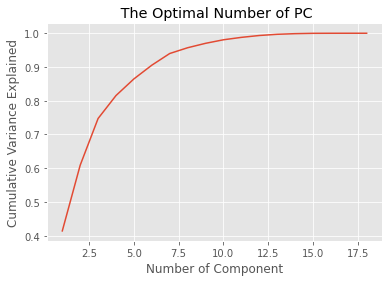

PCA  ALL
----------------------------------------------------------------------------------------


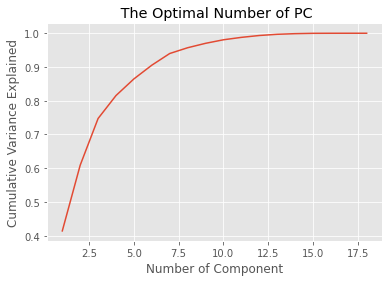

,PC 1 (41.4%),PC 2 (19.5%),PC 3 (13.8%),PC 4 (6.8%),PC 5 (4.9%),PC 6 (4.1%)
Air pressure (upper boom),-0.473313,-0.039298,-0.276173,0.349736,-0.698049,0.050834
Air temperature (upper boom),-0.956211,0.080704,0.228778,-0.020200,-0.041464,-0.046719
Relative humidity (upper boom) - corrected,0.138782,-0.884148,0.104549,0.046149,0.015488,0.245624
Specific humidity (upper boom),-0.931236,-0.169447,0.217519,0.124114,0.058502,0.037098
Wind speed (upper boom),-0.034676,0.774386,0.422987,-0.016191,0.014665,0.341143
Downwelling shortwave radiation - corrected,-0.760672,-0.005576,-0.592894,-0.087039,0.121121,0.141959
Upwelling shortwave radiation - corrected,-0.672405,-0.038189,-0.647437,-0.224527,0.037621,0.198235
Downwelling longwave radiation,-0.779192,-0.337448,0.478932,-0.163393,-0.000697,-0.004608
Upwelling longwave radiation,-0.966743,-0.006771,0.195706,-0.091526,-0.042578,-0.042258
Surface temperature,-0.954639,0.012156,0.197852,-0.117267,-0.066930,-0.046951


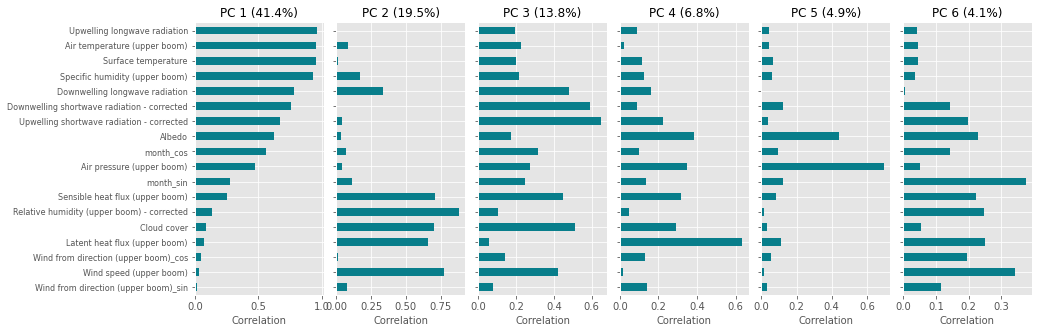

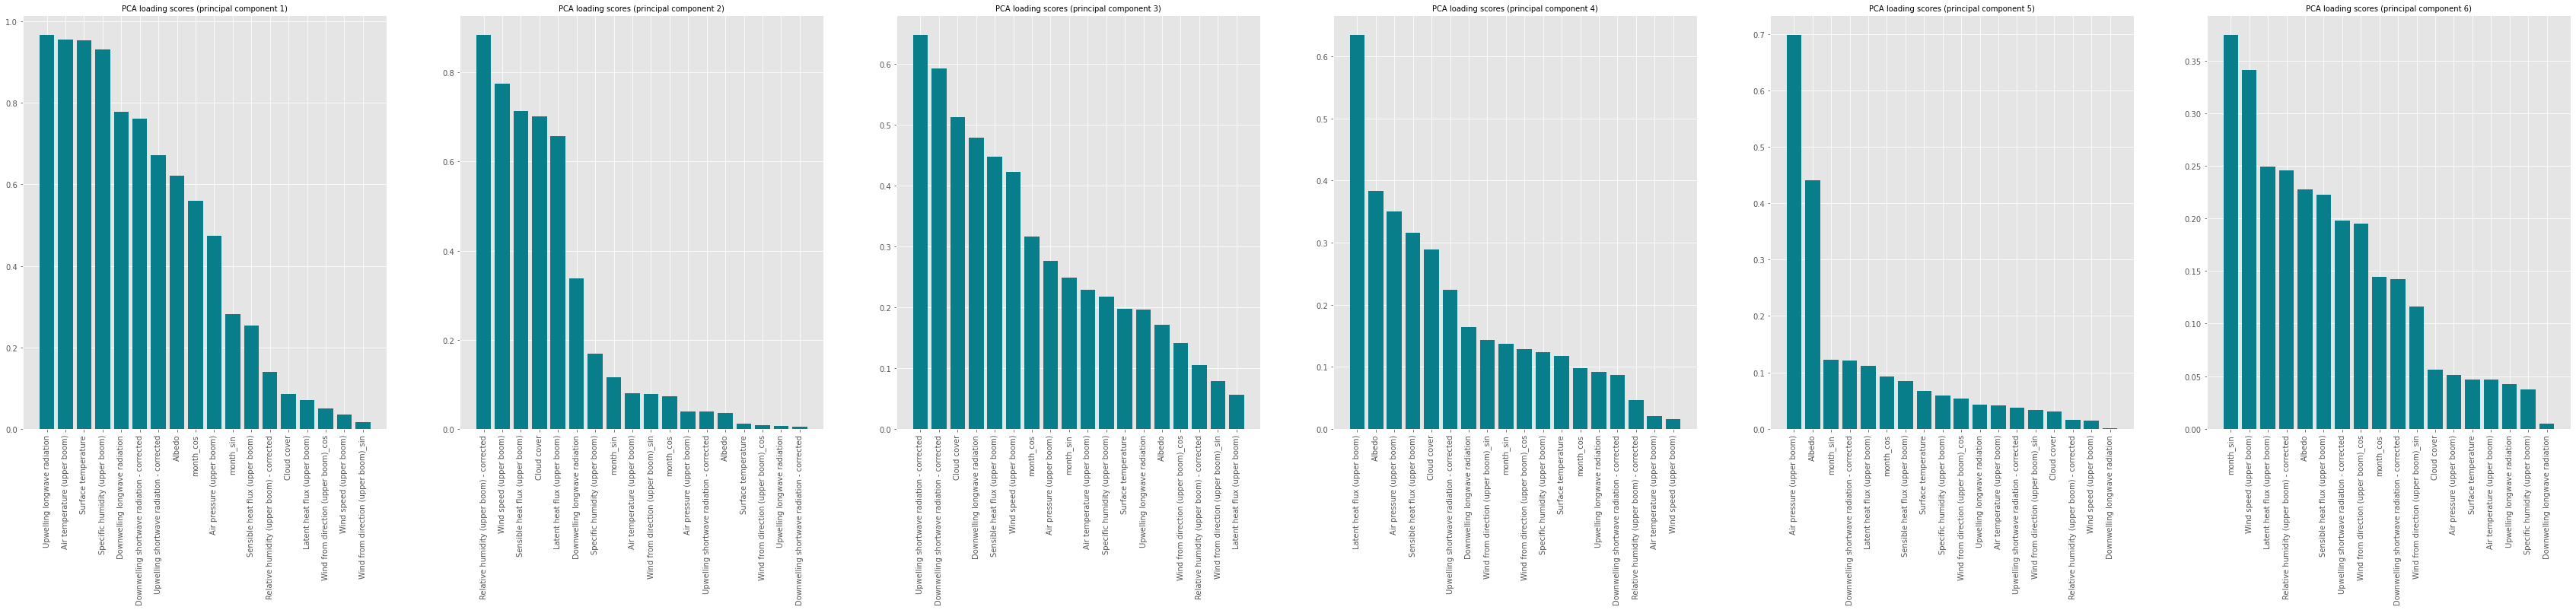

PCA  PRE
----------------------------------------------------------------------------------------


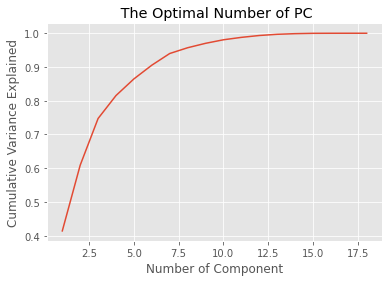

,PC 1 (39.6%),PC 2 (22.0%),PC 3 (14.2%),PC 4 (7.1%),PC 5 (4.6%),PC 6 (3.8%)
Air pressure (upper boom),0.473850,-0.343130,-0.283699,0.709031,-0.456566,-0.142543
Air temperature (upper boom),0.922279,-0.042014,0.205581,0.047985,0.094890,0.048229
Relative humidity (upper boom) - corrected,-0.439754,-0.757359,0.320213,0.147267,0.093848,0.086434
Specific humidity (upper boom),0.647640,-0.187282,0.211653,0.123368,0.170112,0.027086
Wind speed (upper boom),0.444264,0.799145,0.204222,0.057633,-0.077785,0.141236
Downwelling shortwave radiation - corrected,0.576530,-0.382572,-0.487667,-0.153594,0.065937,0.074760
Upwelling shortwave radiation - corrected,0.580481,-0.507353,-0.542969,-0.219819,-0.027398,0.217123
Downwelling longwave radiation,0.609538,-0.306272,0.585357,-0.066918,-0.038038,-0.063501
Upwelling longwave radiation,0.910674,-0.153916,0.200155,-0.008494,0.064439,0.029385
Surface temperature,0.949502,-0.148842,0.198570,-0.015110,0.059424,0.047178


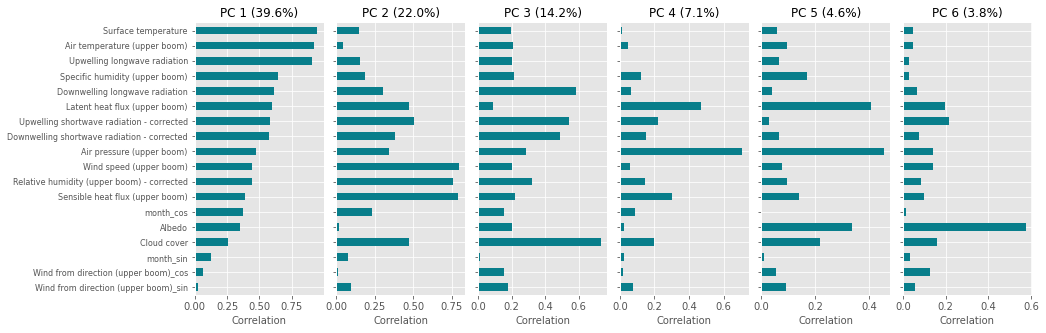

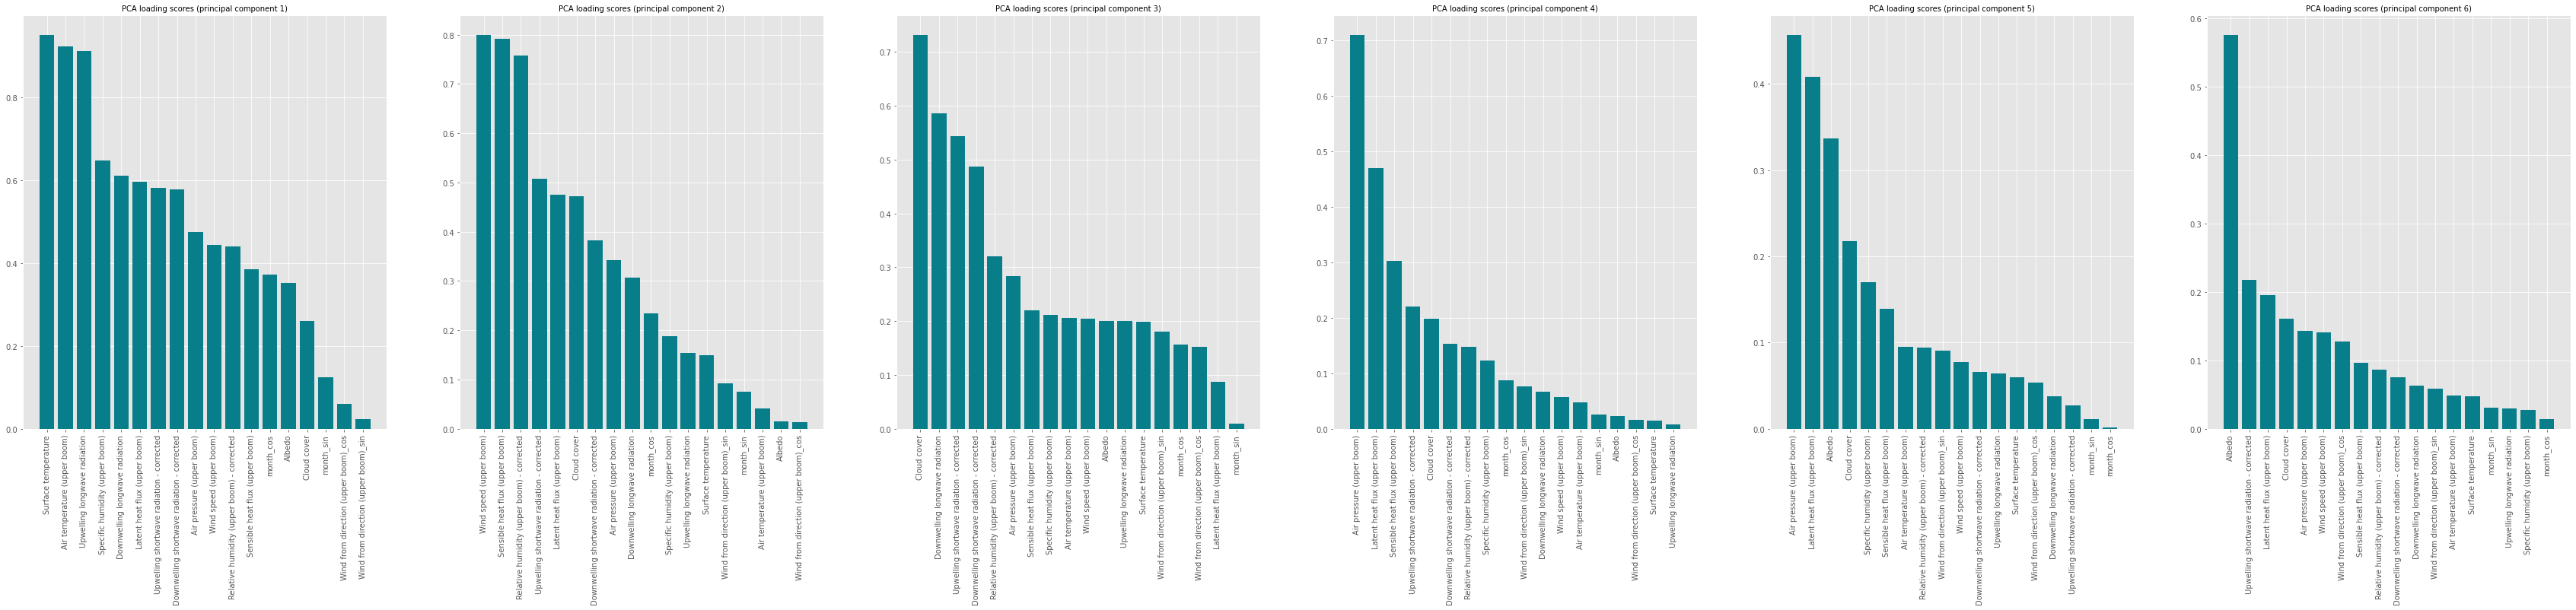

PCA  BEGINNING
----------------------------------------------------------------------------------------


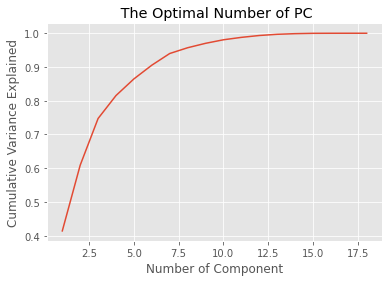

,PC 1 (38.9%),PC 2 (28.9%),PC 3 (13.1%),PC 4 (7.8%),PC 5 (4.0%),PC 6 (2.2%)
Air pressure (upper boom),0.053159,-0.063363,-0.070950,-0.519335,0.321060,0.009757
Air temperature (upper boom),0.087274,0.168159,0.069440,-0.064836,-0.038524,-0.043444
Relative humidity (upper boom) - corrected,-0.702376,-0.098234,0.307010,0.182577,0.153959,0.156898
Specific humidity (upper boom),-0.151413,0.236596,0.259649,-0.024493,-0.018286,-0.007166
Wind speed (upper boom),0.449840,0.329637,-0.078251,0.188925,0.134342,0.188045
Downwelling shortwave radiation - corrected,0.365115,-0.368785,0.200920,0.004150,0.041031,-0.050159
Upwelling shortwave radiation - corrected,0.251409,-0.512942,0.032293,0.147775,0.147914,-0.055431
Downwelling longwave radiation,-0.343395,0.426571,-0.144345,-0.058031,-0.009082,-0.050637
Upwelling longwave radiation,0.008034,0.094369,0.027462,-0.042124,-0.032208,-0.029223
Surface temperature,-0.001201,0.053040,0.023442,-0.029673,-0.024207,-0.013057


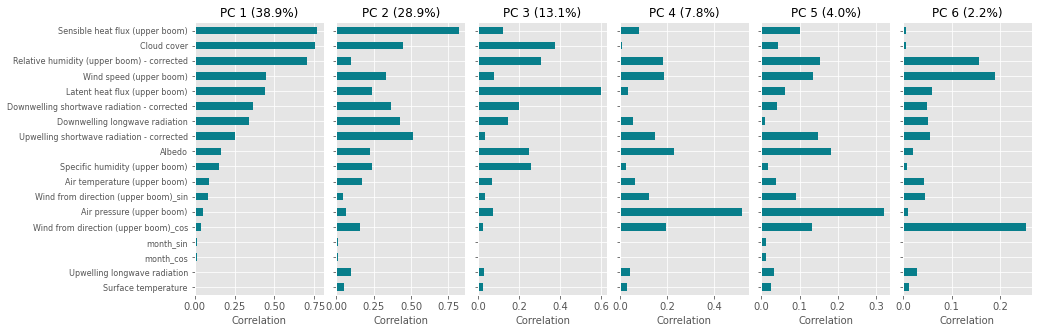

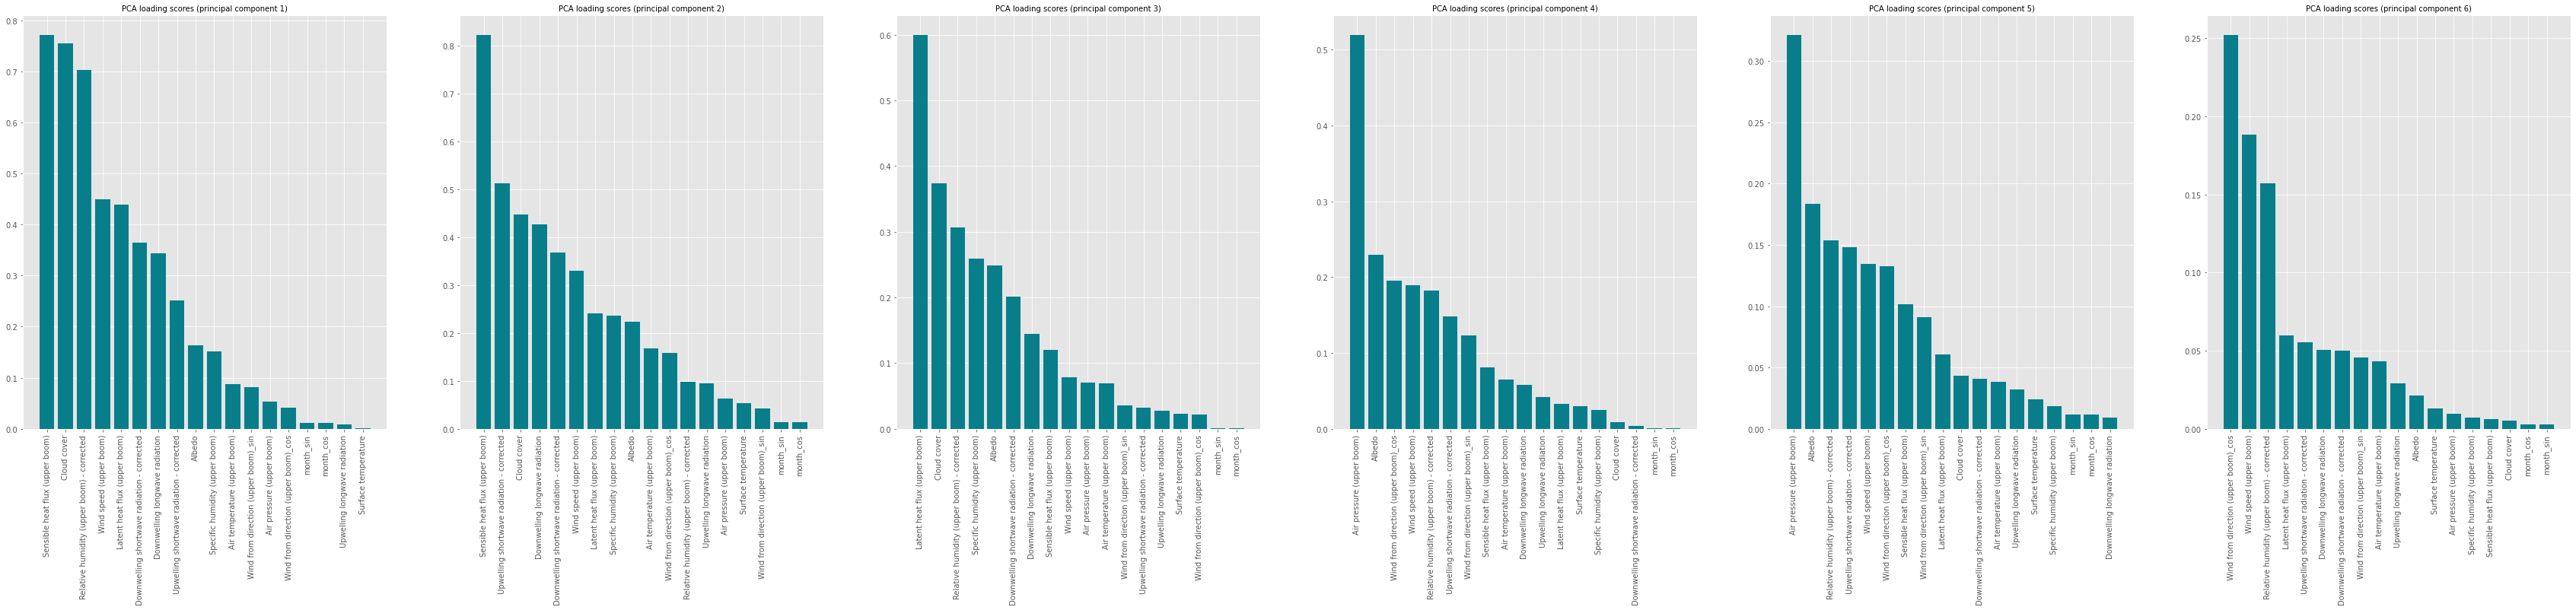

PCA  MIDDLE
----------------------------------------------------------------------------------------


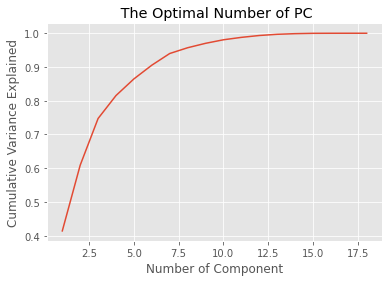

,PC 1 (39.8%),PC 2 (25.0%),PC 3 (12.9%),PC 4 (6.3%),PC 5 (5.6%),PC 6 (4.3%)
Air pressure (upper boom),-0.061350,0.151870,0.208833,-0.339451,-0.091821,0.398187
Air temperature (upper boom),-0.002280,0.170892,-0.003558,-0.068315,0.000344,-0.027249
Relative humidity (upper boom) - corrected,0.628121,-0.238944,0.380118,0.156633,0.007407,0.007703
Specific humidity (upper boom),0.291202,0.223672,0.169653,-0.026932,-0.004989,-0.059060
Wind speed (upper boom),-0.120215,0.452890,-0.200568,0.120769,0.072635,0.032217
Downwelling shortwave radiation - corrected,-0.544249,0.075423,0.357761,-0.080235,0.225124,-0.068033
Upwelling shortwave radiation - corrected,-0.464342,-0.079580,0.286120,0.044394,0.253952,0.009282
Downwelling longwave radiation,0.501065,0.073455,-0.133503,-0.177868,0.145870,-0.034129
Upwelling longwave radiation,0.026732,0.067412,0.001668,-0.052813,0.014091,-0.015396
Surface temperature,0.009957,0.026586,0.008226,-0.032306,0.002427,-0.012671


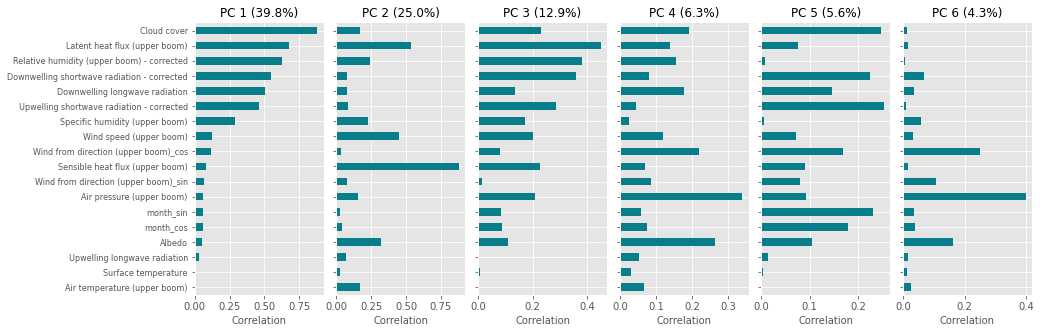

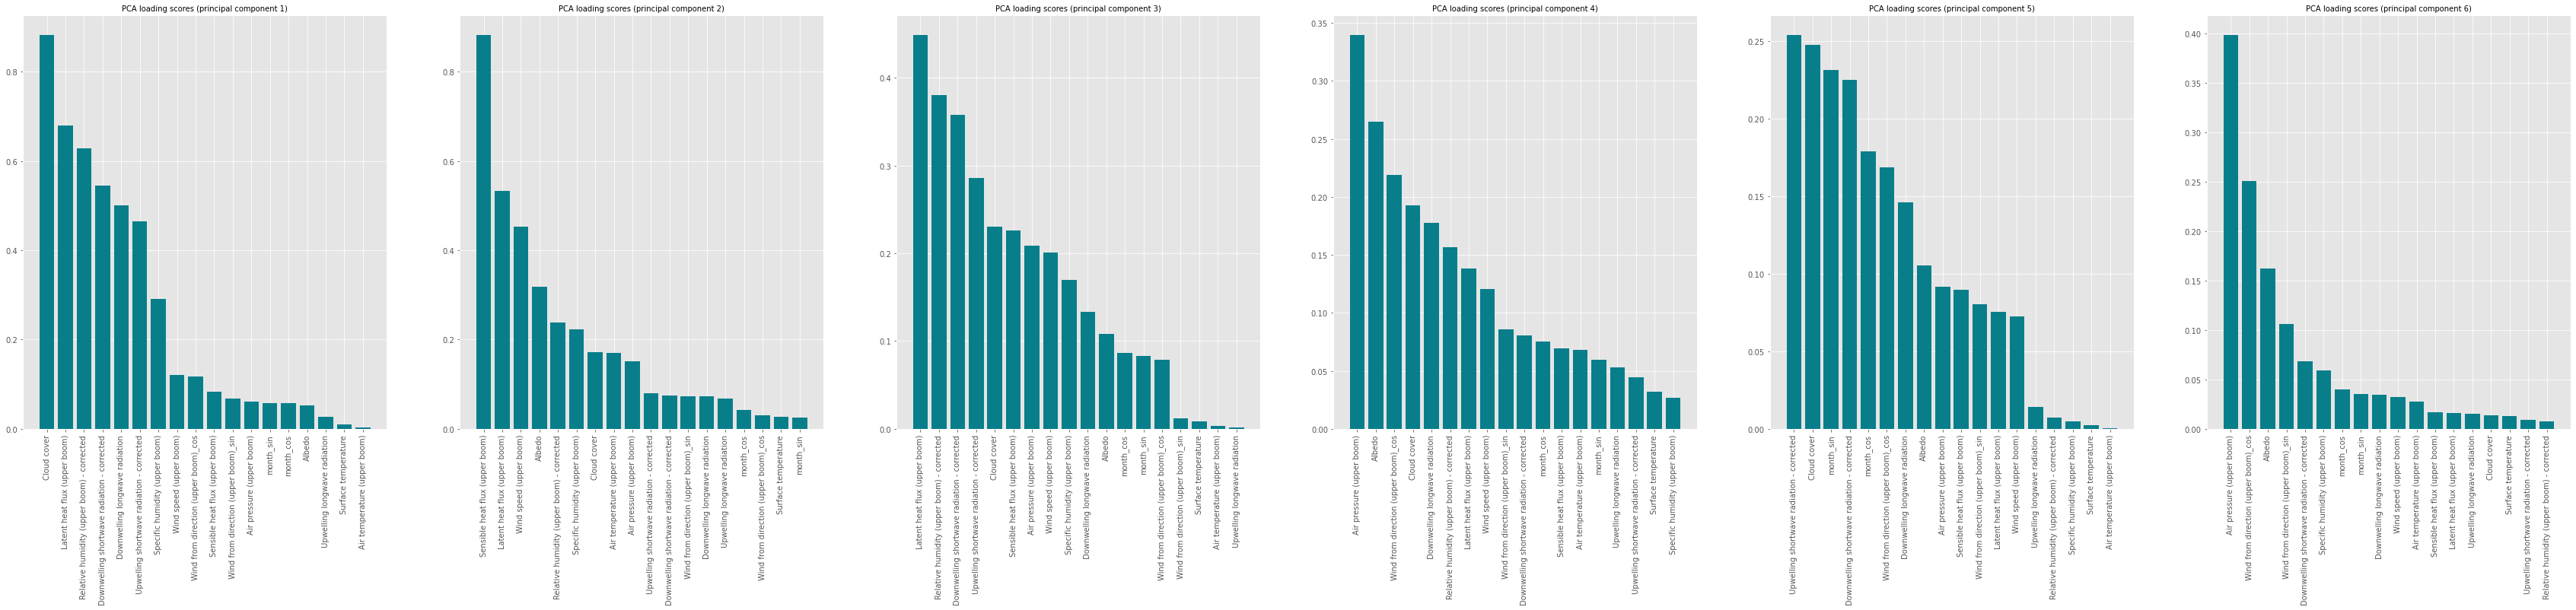

PCA  END
----------------------------------------------------------------------------------------


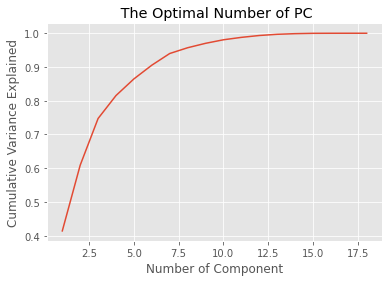

,PC 1 (40.1%),PC 2 (25.7%),PC 3 (11.9%),PC 4 (7.1%),PC 5 (5.4%),PC 6 (2.9%)
Air pressure (upper boom),0.031231,-0.115824,-0.298608,0.118872,0.565681,0.146732
Air temperature (upper boom),-0.040627,0.333385,-0.056115,-0.118076,0.071362,-0.109581
Relative humidity (upper boom) - corrected,-0.862416,-0.168218,-0.069781,0.085491,-0.011269,-0.051736
Specific humidity (upper boom),-0.348566,0.453145,-0.138431,-0.094783,0.063609,-0.150673
Wind speed (upper boom),0.437385,0.537414,0.258707,0.272532,0.020908,-0.012508
Downwelling shortwave radiation - corrected,0.209675,-0.124364,-0.159141,-0.076835,0.064998,-0.149622
Upwelling shortwave radiation - corrected,0.211822,-0.272735,-0.063043,-0.017637,0.118163,-0.192224
Downwelling longwave radiation,-0.574561,0.418223,0.142255,-0.144229,0.098290,-0.000197
Upwelling longwave radiation,-0.118844,0.299208,-0.042390,-0.165065,0.079249,-0.117449
Surface temperature,-0.092625,0.245114,-0.034001,-0.169110,0.074233,-0.117056


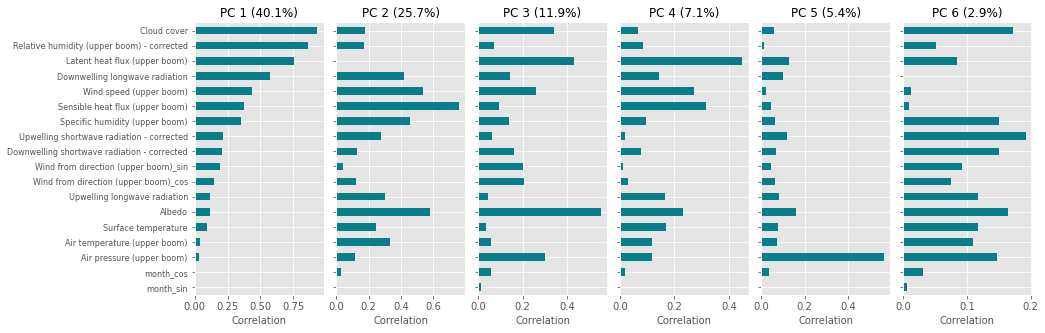

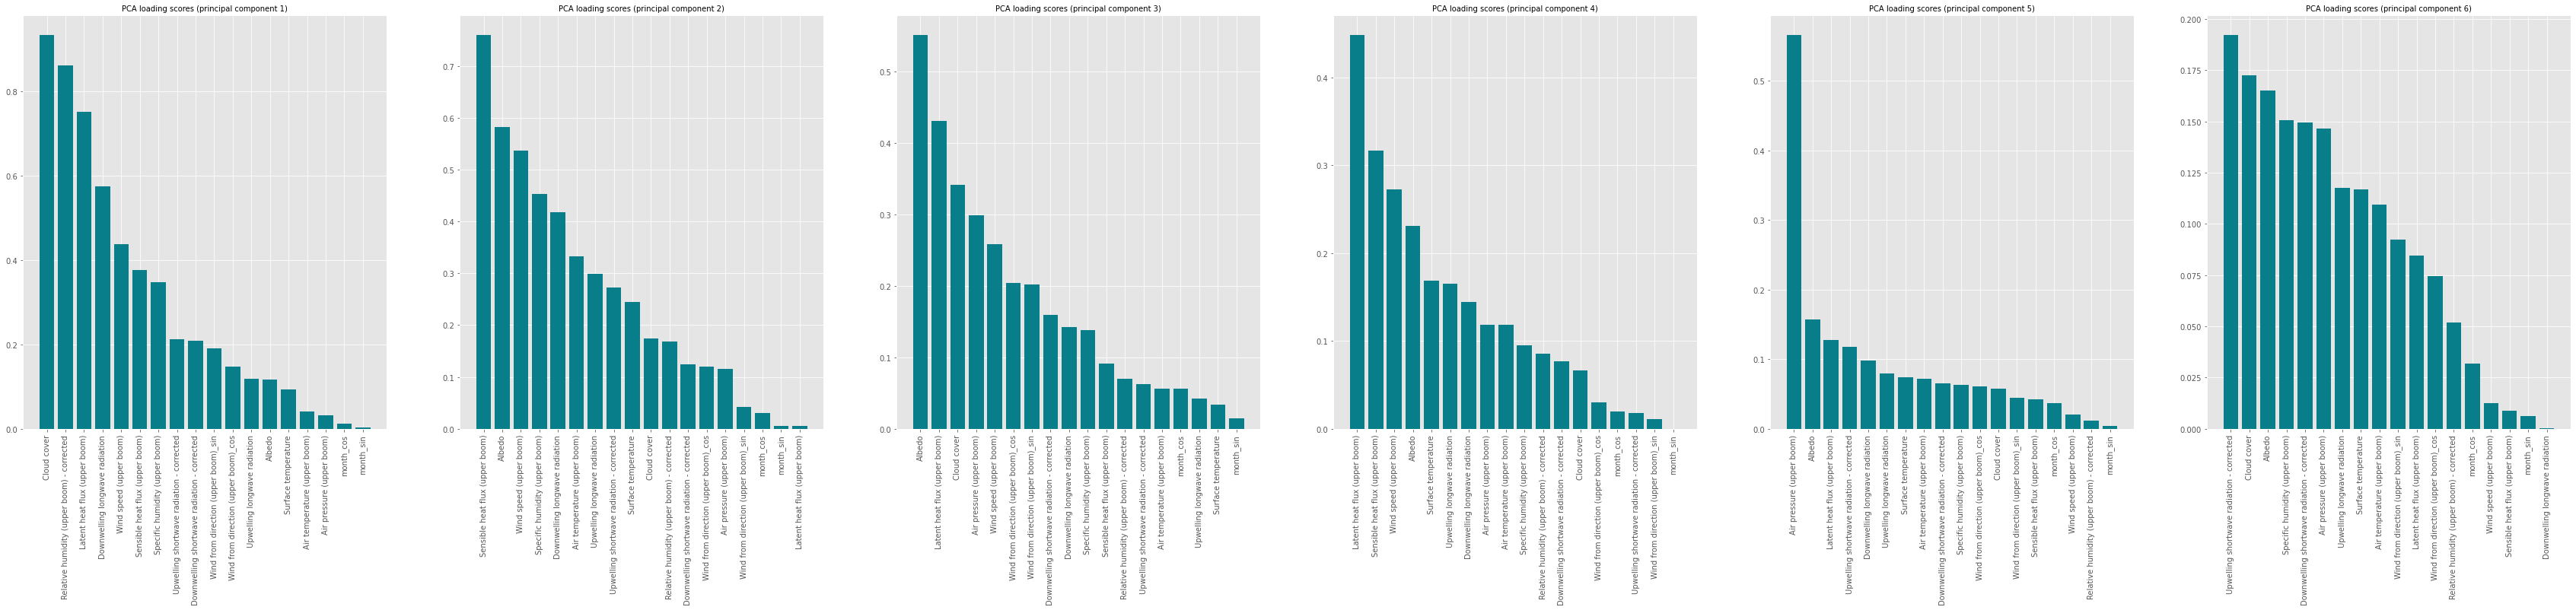

In [31]:
# Apply PCA
from sklearn.decomposition import PCA

pca_col = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements DELTA', 'Surface height from combined measurements'], axis=1).columns #select numerical columns except y
for period in periods:
    indices = eval(f'indices_{period}')
    print('PCA ', period.upper())
    print('----------------------------------------------------------------------------------------')

    # Find common indexes
    df_valid_indices = indices.intersection(df.index)

    # filter out by indeces
    df_category = df.loc[df_valid_indices]

    pca = PCA()
    pca.fit(df[pca_col])

    cumulative_variance_explained = np.cumsum(pca.explained_variance_ratio_)
    x_values = list(range(1, len(cumulative_variance_explained)+1))

    #Visualizing arm-bar plot 
    plot_cum_variance(x_values, cumulative_variance_explained)


    #Identify the optimal number of principal components 
    optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

    #Transform data with the optimal number of components
    pca = PCA(n_components = optimal_component)

    pca_data = pca.fit_transform(df_category[pca_col])

    labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }

    labels_vals = list(labels.values())
    loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  df_category[pca_col].columns
    )
    display(loadings)



    plot_pca_vert(labels_vals, loadings, absolute=True)
    plot_pca_loadings(labels_vals, loadings)



---------------------

### Test Suite

<class 'numpy.ndarray'>


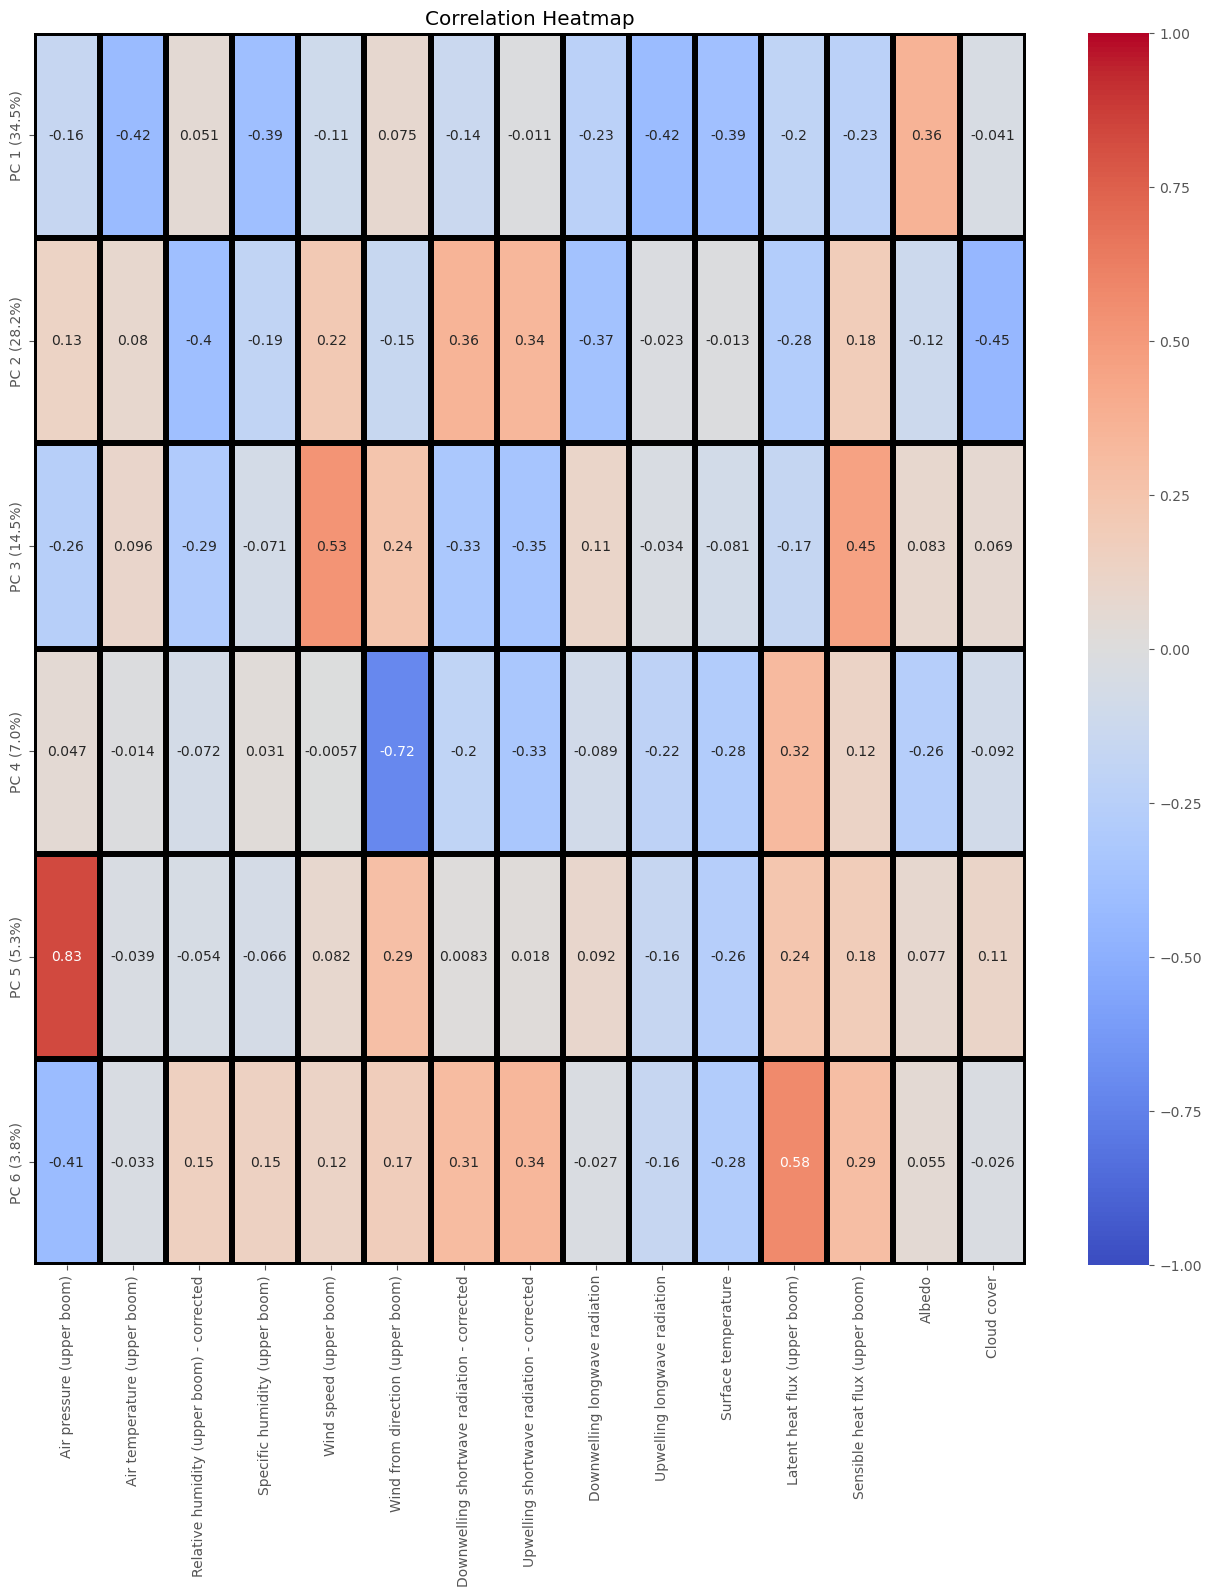

In [297]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

#Transform data with the optimal number of components
pca = PCA(n_components = optimal_component)

X_train_pca = pca.fit_transform(X_train[num_cols])
X_test_pca = pca.transform(X_test[num_cols])

labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_*100)
    }
print(type(pca.explained_variance_ratio_))


def pca_relationship(pca_model):
    color_map = {
    'beginning': 'green',
    'middle': 'yellow',
    'end': 'red'
    }
    fig = px.scatter_matrix(
        pca_model,
        labels=labels,
        dimensions=range(4),
        color=X_train['Melting Season'],
        color_discrete_map=color_map)
    
    fig.update_traces(diagonal_visible=False)
    fig.show()

def pca_heatmap(dataframe):
    #plot a heatmap to visualise how the feature variables contribute to PC
    # Heatmap
    plt.figure(figsize=(16, 16))

    heatmap = sns.heatmap(dataframe, annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')

    heatmap.set_title('Correlation Heatmap')
    plt.show()

pca_df = pd.DataFrame(pca.components_,
                columns = num_cols,
                index =labels.values(),
                )
pca_heatmap(pca_df)
pca_relationship(X_train_pca)




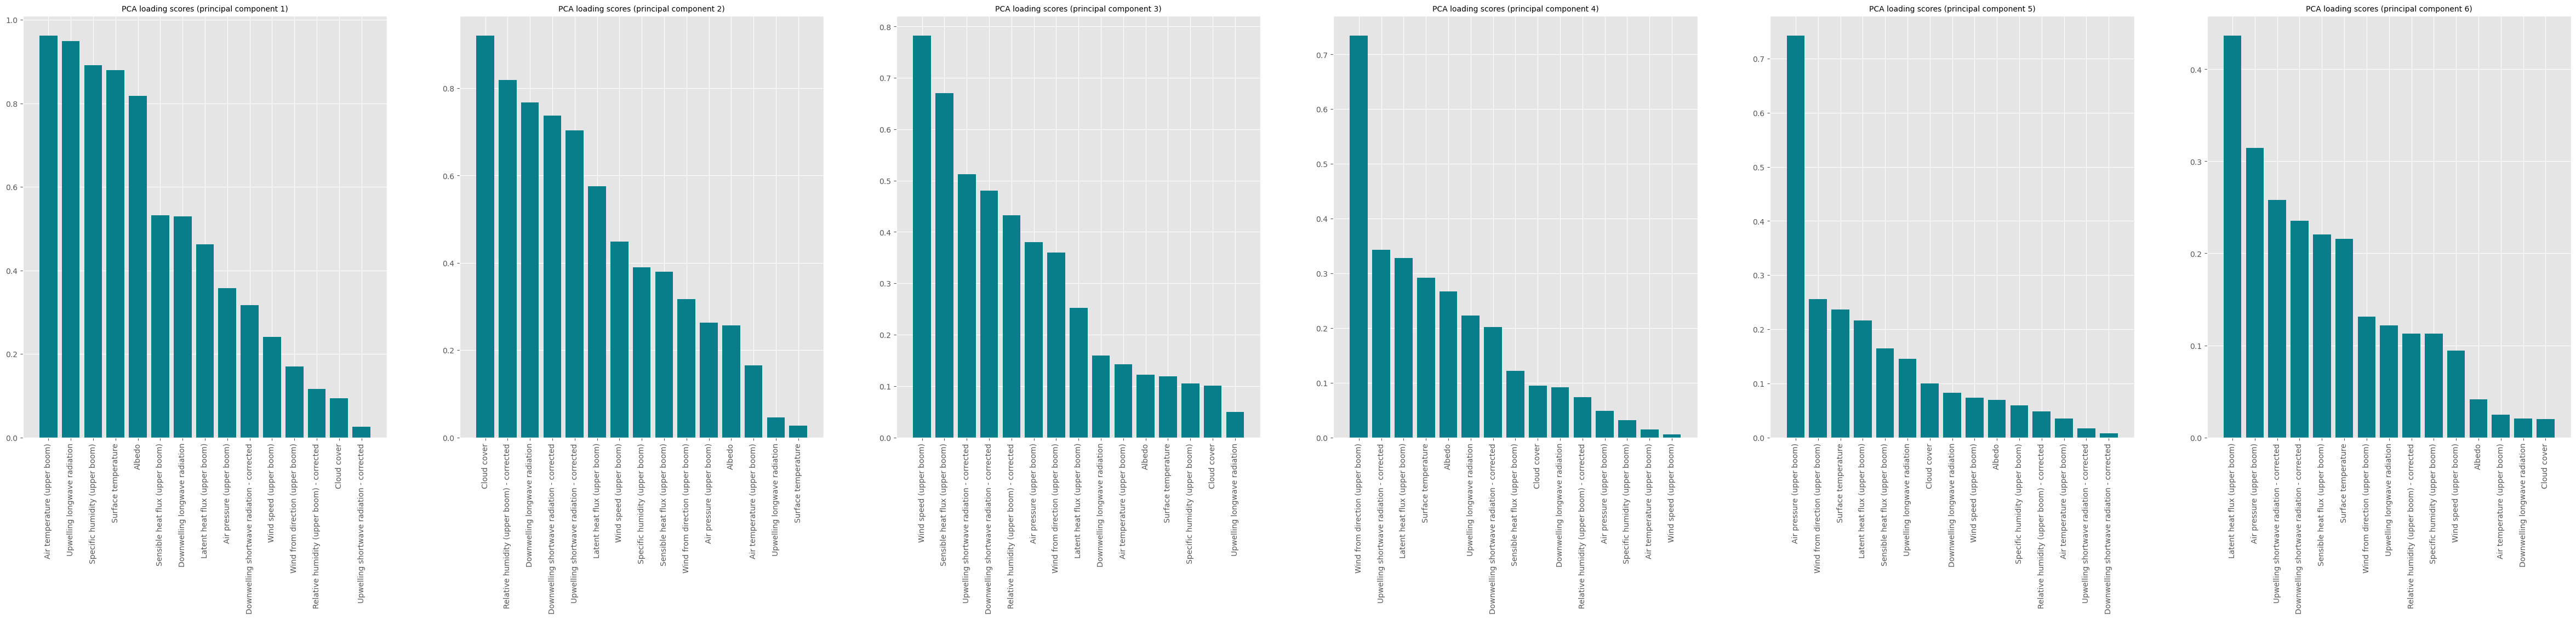

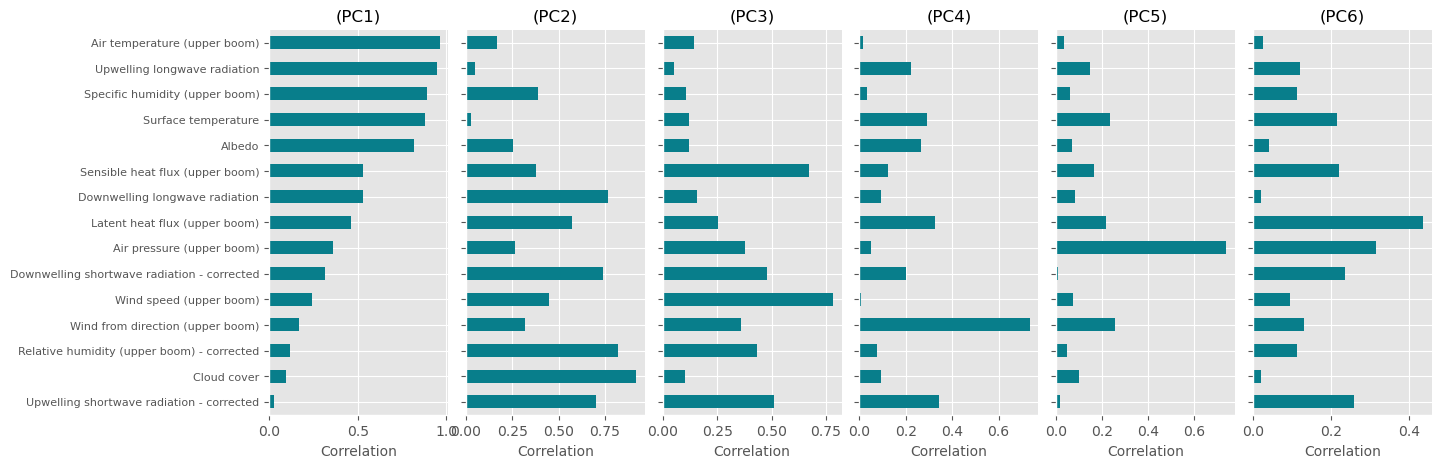

In [298]:
labels_vals = list(labels.values())
loadings = pd.DataFrame(
    data=pca.components_.T * np.sqrt(pca.explained_variance_), 
    columns= labels_vals,
    index=  X_train[num_cols].columns
)

def plot_pca_loadings(labels_vals, loadings):
    fig, axes = plt.subplots(1, len(labels_vals), figsize=(len(labels_vals)*10, 10))

    for i, label in enumerate(labels_vals):
        pc_loadings = loadings.abs().sort_values(by=label, ascending=False)[[label]]
        pc_loadings = pc_loadings.reset_index()
        pc_loadings.columns = ['Attribute', 'CorrelationWithPC{}'.format(i+1)]
        axes[i].bar(x=pc_loadings['Attribute'], height=pc_loadings['CorrelationWithPC{}'.format(i+1)], color='#087E8B')
        axes[i].set_title('PCA loading scores (principal component {})'.format(i+1), size=10)
        axes[i].tick_params(axis='x', rotation=90)

    plt.show()

plot_pca_loadings(labels_vals, loadings)


def plot_pca_stacked(labels_vals, loadings):
    fig, axs = plt.subplots(nrows=len(loadings.columns), sharey=True, figsize=(8, 10))

    # Loop over each column in the loadings dataframe and create a bar chart for each feature
    for i, col in enumerate(loadings.columns):
        axs[i].bar(x=loadings.index, height=loadings[col].abs(), color='#087E8B')
        axs[i].set_title(col)
        axs[i].tick_params(labelbottom=False, bottom=False)  # Hide x-axis labels and ticks for all subplots except the bottom one
        axs[i].spines['right'].set_visible(False)  # Hide right spines for all subplots
        axs[i].spines['top'].set_visible(False)  # Hide top spines for all subplots
        if i == len(loadings.columns) - 1:
            axs[i].tick_params(labelbottom=True, bottom=True, labelrotation=90)

    # Set y-axis label and adjust subplots layout
    fig.text(0, 0.5, 'Contribution to PCA', va='center', rotation='vertical')
    fig.tight_layout(pad=1.5)
    plt.show()

#plot_pca_stacked(labels_vals, loadings)

def plot_pca_vert(labels_vals,loadings, absolute=False):
    plt.style.use('ggplot')
    fig, axes = plt.subplots(nrows=1, ncols=len(loadings.columns), figsize=(15,5), sharey=True)
    if absolute:
        loadings = loadings.abs()
    loadings = loadings.sort_values(by=loadings.columns[0],ascending=True)
    for i, col in enumerate(loadings.columns):

        loadings[col].plot(kind='barh', ax=axes[i], color='#087E8B')
            
        axes[i].set_title(f'(PC{i+1})', size=12)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('Correlation', size=10)
        axes[i].tick_params(axis='y', rotation=0, labelsize=8)
        axes[i].set_yticks(np.arange(len(loadings.index)))
        axes[i].set_yticklabels(loadings.index, fontsize=8)
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()

plot_pca_vert(labels_vals, loadings, absolute=True)

-------------------------------- Without Imputation ---------------------------------------------------

In [299]:
#  We can follow this paper: https://www.sciencedirect.com/science/article/pii/S1574954121000261#:~:text=The%20standard%20algorithm%20of%20PCA%20is%20modified%20to%20accommodate%20incomplete%20data.&text=The%20method%20produces%20ordination%20scores%20for%20variables%20and%20observations%20simultaneously.&text=Information%20is%20maximally%20exhausted%2C%20while%20data%20imputation%20is%20not%20required.
# Or: https://github.com/allentran/pca-magic

import os

import numpy as np
from scipy.linalg import orth

class PPCA():

    def __init__(self):

        self.raw = None   # original data
        self.data = None  # standardized data
        self.C = None     # principal component matrix
        self.means = None # mean of data
        self.stds = None  # standard deviation of data
        self.eig_vals = None # eigenvalues of the covariance matrix

    def _standardize(self, X):
        """
        Internal function to standardize input data.

        Args:
            X (array): Input data to be standardized.

        Returns:
            array: Standardized data.
        """

        if self.means is None or self.stds is None:
            raise RuntimeError("Fit model first")

        return (X - self.means) / self.stds

    def fit(self, data, d=None, tol=1e-4, min_obs=10, verbose=False):
        """
        Fit the PPCA model to the input data.

        Args:
            data (array): Input data to fit the model.
            d (int, optional): Number of principal components to keep. Defaults to None, which is the same as the number of dimensions of the data.
            tol (float, optional): Tolerance for convergence. Defaults to 1e-4.
            min_obs (int, optional): Minimum number of observations required for a variable to be included in the model. Defaults to 10.
            verbose (bool, optional): Print the difference value for each iteration. Defaults to False.

        Raises:
            RuntimeError: If the model is not fit before calling _standardize function.

        Returns:
            None
        """

        self.raw = data
        self.raw[np.isinf(self.raw)] = np.max(self.raw[np.isfinite(self.raw)])

        valid_series = np.sum(~np.isnan(self.raw), axis=0) >= min_obs

        data = self.raw[:, valid_series].copy()
        N = data.shape[0]
        D = data.shape[1]

        self.means = np.nanmean(data, axis=0)
        self.stds = np.nanstd(data, axis=0)

        data = self._standardize(data)
        observed = ~np.isnan(data)
        missing = np.sum(~observed)
        data[~observed] = 0

        # initial

        if d is None:
            d = data.shape[1]
        
        if self.C is None:
            C = np.random.randn(D, d)
        else:
            C = self.C
        CC = np.dot(C.T, C)
        X = np.dot(np.dot(data, C), np.linalg.inv(CC))
        recon = np.dot(X, C.T)
        recon[~observed] = 0
        ss = np.sum((recon - data)**2)/(N*D - missing)

        v0 = np.inf
        counter = 0

        while True:

            Sx = np.linalg.inv(np.eye(d) + CC/ss)

            # e-step
            ss0 = ss
            if missing > 0:
                proj = np.dot(X, C.T)
                data[~observed] = proj[~observed]
            X = np.dot(np.dot(data, C), Sx) / ss

            # m-step
            XX = np.dot(X.T, X)
            C = np.dot(np.dot(data.T, X), np.linalg.pinv(XX + N*Sx))
            CC = np.dot(C.T, C)
            recon = np.dot(X, C.T)
            recon[~observed] = 0
            ss = (np.sum((recon-data)**2) + N*np.sum(CC*Sx) + missing*ss0)/(N*D)

            # calc diff for convergence
            det = np.log(np.linalg.det(Sx))
            if np.isinf(det):
                det = abs(np.linalg.slogdet(Sx)[1])
            v1 = N*(D*np.log(ss) + np.trace(Sx) - det) \
                + np.trace(XX) - missing*np.log(ss0)
            diff = abs(v1/v0 - 1)
            if verbose:
                print(diff)
            if (diff < tol) and (counter > 5):
                break

            counter += 1
            v0 = v1


        C = orth(C)
        vals, vecs = np.linalg.eig(np.cov(np.dot(data, C).T))
        order = np.flipud(np.argsort(vals))
        vecs = vecs[:, order]
        vals = vals[order]

        C = np.dot(C, vecs)

        # attach objects to class
        self.C = C
        self.data = data
        self.eig_vals = vals
        self._calc_var()

    def transform(self, data=None):

        if self.C is None:
            raise RuntimeError('Fit the data model first.')
        if data is None:
            return np.dot(self.data, self.C)
        return np.dot(data, self.C)

    def _calc_var(self):

        if self.data is None:
            raise RuntimeError('Fit the data model first.')

        data = self.data.T

        # variance calc
        var = np.nanvar(data, axis=1)
        total_var = var.sum()
        self.var_exp = self.eig_vals.cumsum() / total_var

    def save(self, fpath):

        np.save(fpath, self.C)
        
    def load(self, fpath):

        assert os.path.isfile(fpath)

        self.C = np.load(fpath)

['Air pressure (upper boom)', 'Air temperature (upper boom)', 'Relative humidity (upper boom) - corrected', 'Specific humidity (upper boom)', 'Wind speed (upper boom)', 'Wind from direction (upper boom)', 'Downwelling shortwave radiation - corrected', 'Upwelling shortwave radiation - corrected', 'Downwelling longwave radiation', 'Upwelling longwave radiation', 'Surface temperature', 'Latent heat flux (upper boom)', 'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover']


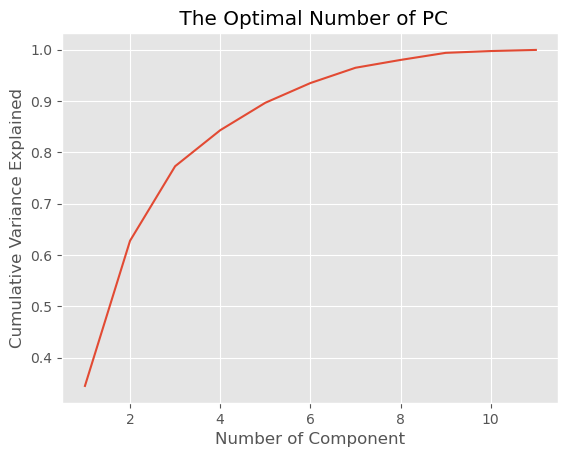

In [301]:
pp_X_train, pp_X_test,pp_y_train, pp_y_test = train_test_split(X,y,
                                   test_size=0.2, 
                                   random_state=2023,
                                   shuffle=False)

# This bit to convert all numerical values into the same scale 
num_cols = X.select_dtypes(include=['int64','float64']).columns.to_list()

scaler = MinMaxScaler()
scaler = StandardScaler()

pp_X_train[num_cols] = scaler.fit_transform(pp_X_train[num_cols])
pp_X_test[num_cols] = scaler.fit_transform(pp_X_test[num_cols])

ppca = PPCA()

ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=30)

# visualizing the amount of variance data explained for each principle component
cumulative_variance_explained = ppca.var_exp
x_values = list(range(1, len(cumulative_variance_explained)+1))

#plot the line graph explaining variance of feature variables through the components
plt.plot(x_values, cumulative_variance_explained)
plt.xlabel('Number of Component')
plt.ylabel('Cumulative Variance Explained')
plt.title(' The Optimal Number of PC')
plt.show()


[0.34521785 0.62791141 0.77309524 0.84313077 0.89655808 0.93479221]
[0.3452178502356563, 0.2826935609490995, 0.14518383244534705, 0.07003552504982036, 0.05342731063348283, 0.03823413219790095]
{'0': 'PC 1 (34.5%)', '1': 'PC 2 (28.3%)', '2': 'PC 3 (14.5%)', '3': 'PC 4 (7.0%)', '4': 'PC 5 (5.3%)', '5': 'PC 6 (3.8%)'}


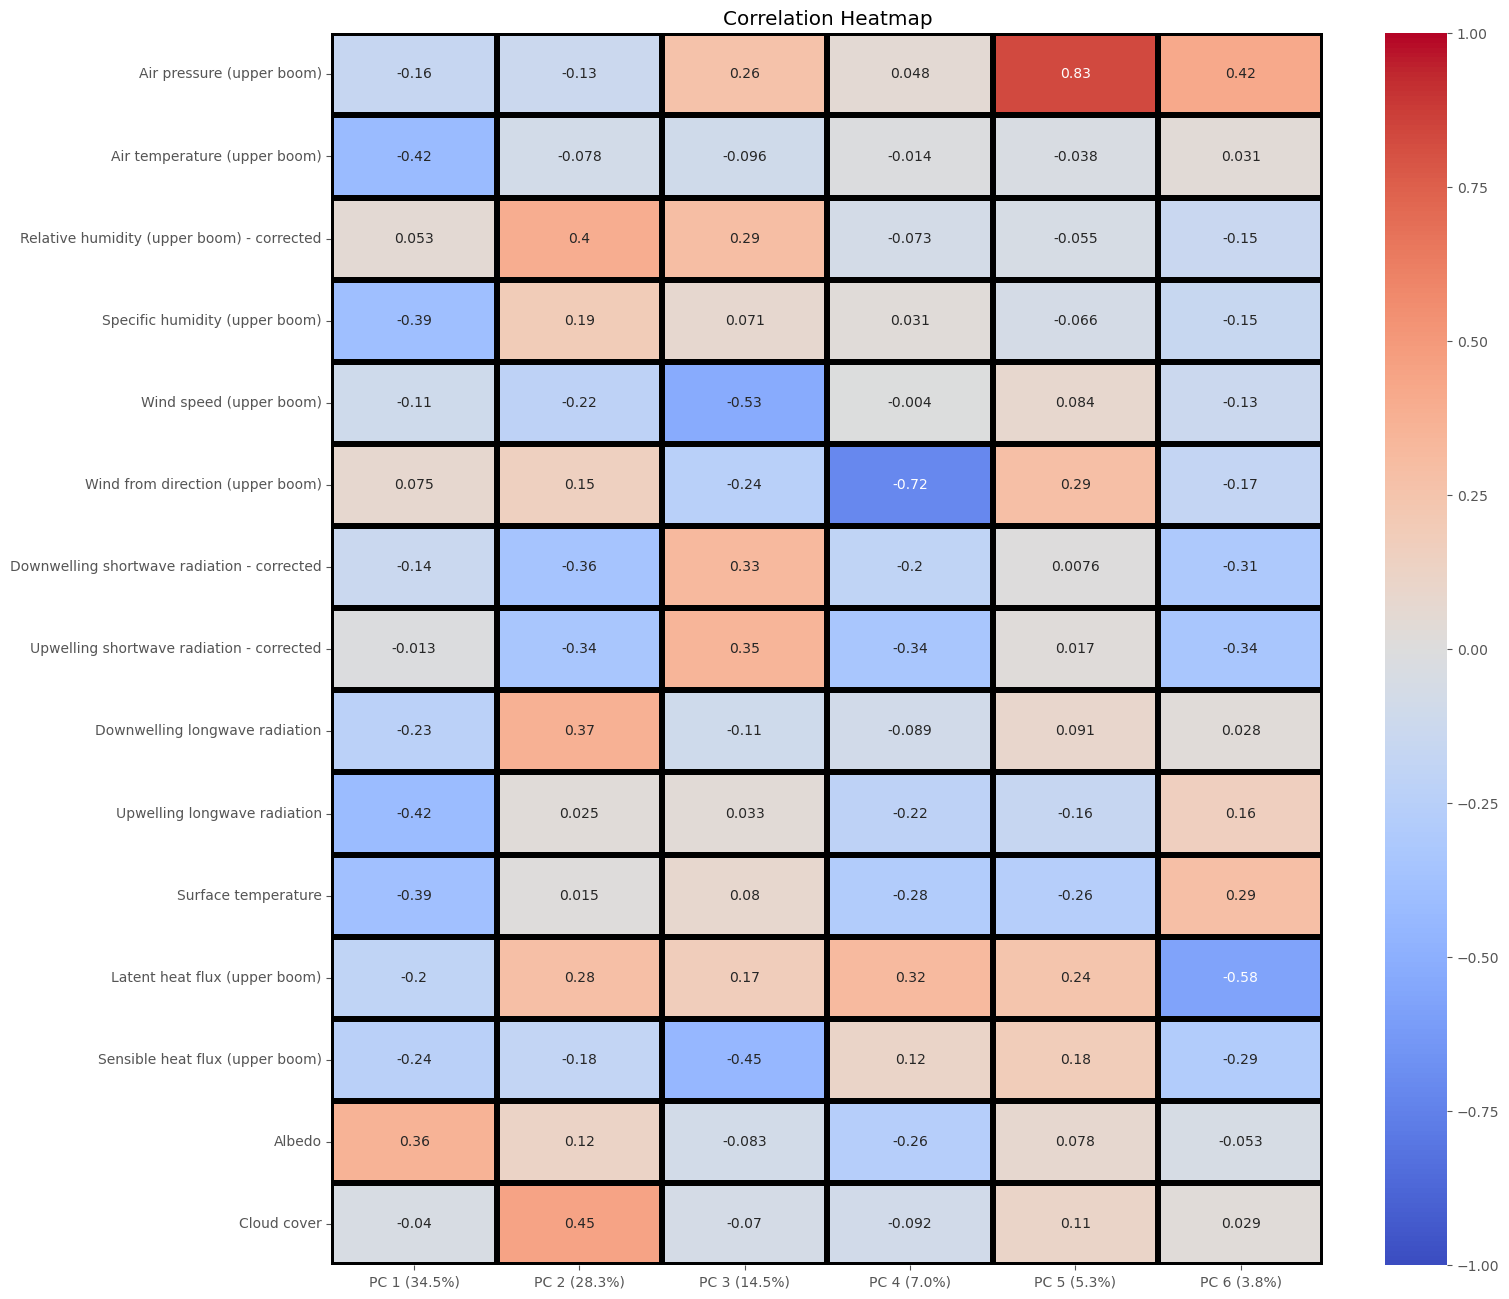

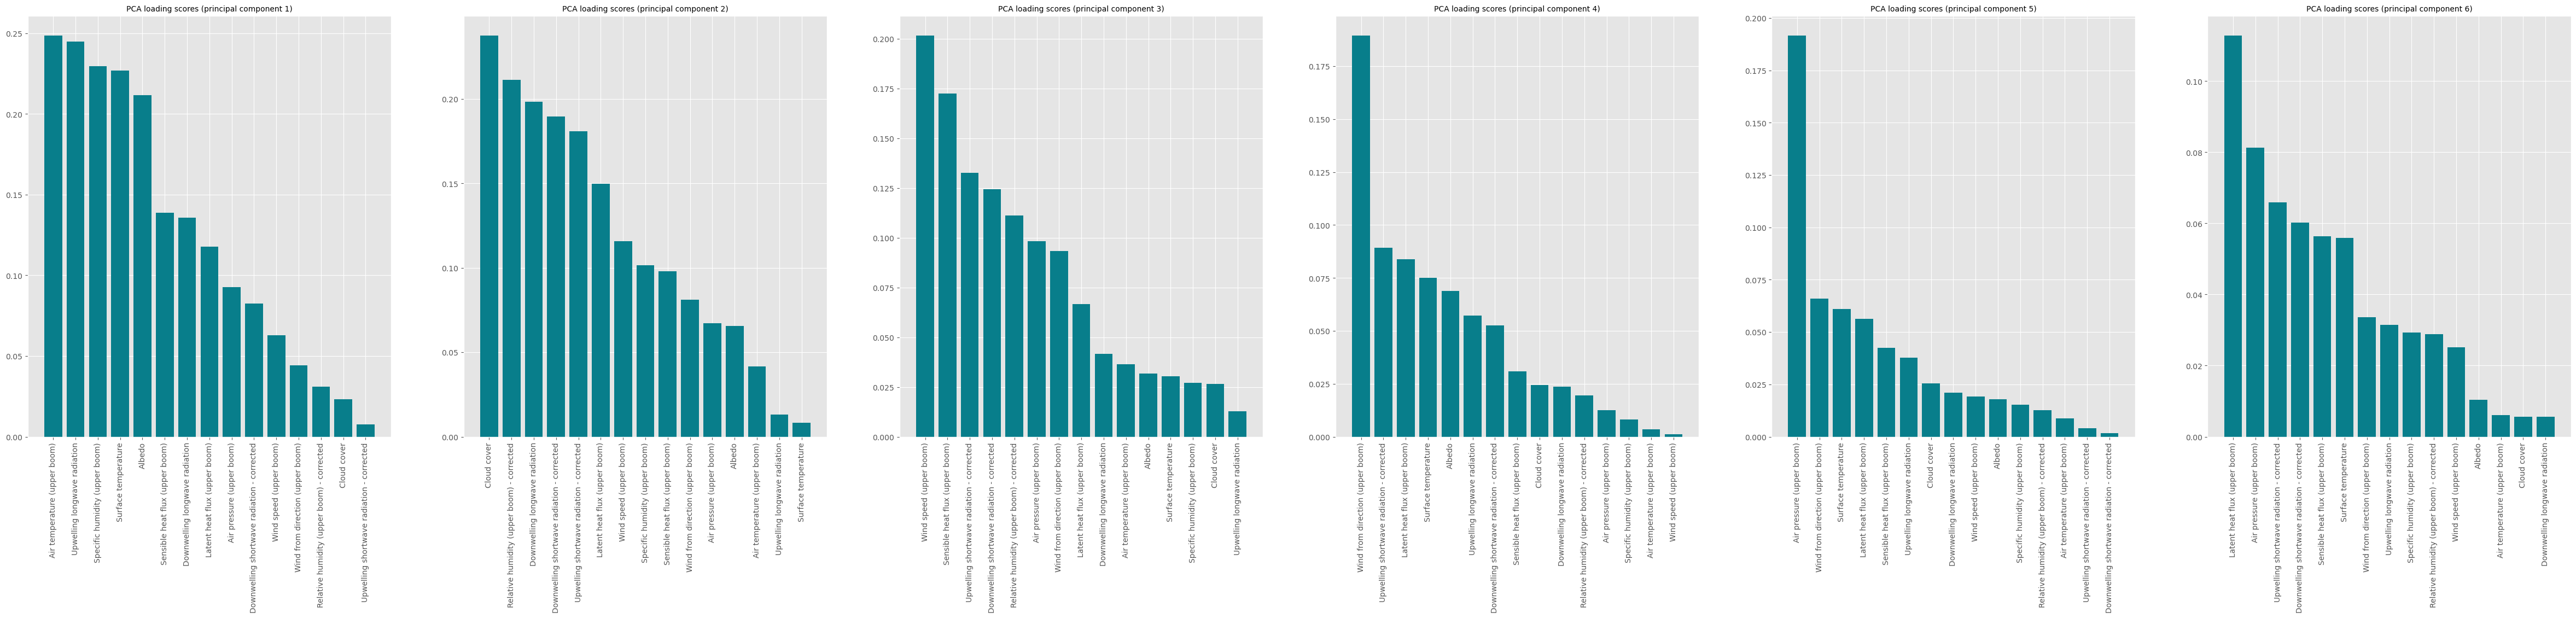

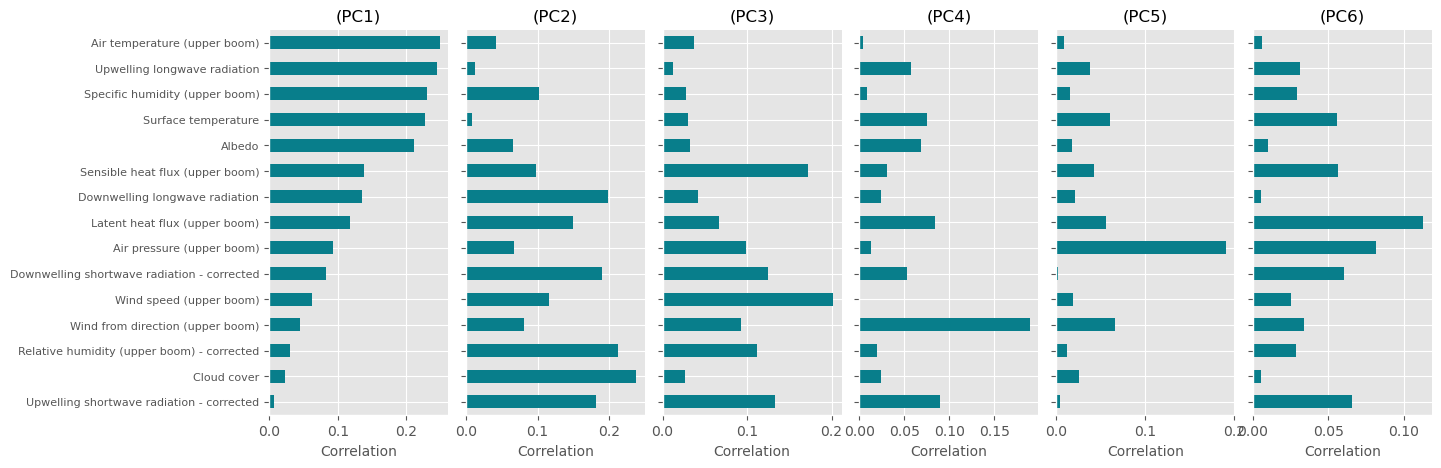

In [306]:
#Identify the optimal number of principal components 
optimal_component = np.argmax(cumulative_variance_explained >=0.9) + 1

variance_explained = [ppca.var_exp[i] - ppca.var_exp[i-1] for i in range(1, len(ppca.var_exp))]
variance_explained.insert(0,ppca.var_exp[0])


ppca_labels = {
    str(i):f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(np.array(variance_explained)*100)
    }

ppca = PPCA()

X_train_ppca = ppca.fit(data = pp_X_train[num_cols].to_numpy(), d=optimal_component) 
X_train_ppca = ppca.transform(X_train_ppca)
X_test_ppca = ppca.transform(pp_X_test[num_cols].to_numpy())

# see how much features contribute to which components
ppca_df = pd.DataFrame(ppca.C,
                       columns = ppca_labels.values(),
                       index =pp_X_train[num_cols].columns)
ppca_df.head()

pca_heatmap(ppca_df)
pca_relationship(X_train_ppca)
pp_labels_vals = list(labels.values())
pp_loadings = pd.DataFrame(
    data=ppca.C * np.sqrt(variance_explained), 
    columns= pp_labels_vals,
    index=  pp_X_train[num_cols].columns
)
plot_pca_loadings(pp_labels_vals, pp_loadings)
plot_pca_vert(pp_labels_vals, pp_loadings, absolute=True)
